# Supervised Modeling

In [104]:
# Core libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Scikit-learn utilities
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

## Data Loading and Preprocessing Decisions

In [105]:
# Configuration and constants
RANDOM_STATE = 42
TARGET_COL = "SalePrice"

# Skewed numeric features to log-transform (from EDA analysis with skewness > 0.75)
SKEWED_FEATURES = [
    'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
    'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
    'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
    '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'
]

# Remove the non-numeric features from skewed features list
for feat in ['MasVnrArea']:
    if feat in SKEWED_FEATURES:
        SKEWED_FEATURES.remove(feat)

POLY_NUM_FEATURES = [
    'OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', '1stFlrSF'
]
# Columns to drop (Id is not useful for prediction)
DROP_COLS = ['Id']

print(f"Configuration:")
print(f"  Random State: {RANDOM_STATE}")
print(f"  Target Column: {TARGET_COL}")
print(f"  Skewed Features to Transform: {len(SKEWED_FEATURES)}")
print(f"  Columns to Drop: {DROP_COLS}")

Configuration:
  Random State: 42
  Target Column: SalePrice
  Skewed Features to Transform: 17
  Columns to Drop: ['Id']


In [106]:
# Load training data (same as in EDA)
train_path = "../data/train.csv"
train_df = pd.read_csv(train_path)

print(f"Training data loaded:")
print(f"  Shape: {train_df.shape}")
print(f"  Samples: {train_df.shape[0]}")
print(f"  Features: {train_df.shape[1]}")

# Drop unnecessary columns
if any(col in train_df.columns for col in DROP_COLS):
    train_df = train_df.drop(columns=DROP_COLS, errors='ignore')
    print(f"\nDropped columns: {DROP_COLS}")
    print(f"  New shape: {train_df.shape}")

# Quick check for missing values
print(f"\nMissing values summary:")
missing_total = train_df.isna().sum().sum()
print(f"  Total missing values: {missing_total}")
print(f"  Columns with missing values: {(train_df.isna().sum() > 0).sum()}")

Training data loaded:
  Shape: (1460, 81)
  Samples: 1460
  Features: 81

Dropped columns: ['Id']
  New shape: (1460, 80)

Missing values summary:
  Total missing values: 7829
  Columns with missing values: 19


In [107]:
# Define target and features
# Apply log transformation to target (decision from EDA)
y = np.log1p(train_df[TARGET_COL])

# Features: all columns except target
X = train_df.drop(columns=[TARGET_COL])

print(f"Target variable (y):")
print(f"  Name: log1p({TARGET_COL})")
print(f"  Shape: {y.shape}")
print(f"  Min: {y.min():.4f}, Max: {y.max():.4f}, Mean: {y.mean():.4f}")

print(f"\nFeature matrix (X):")
print(f"  Shape: {X.shape}")
print(f"  Features: {X.shape[1]}")

Target variable (y):
  Name: log1p(SalePrice)
  Shape: (1460,)
  Min: 10.4603, Max: 13.5345, Mean: 12.0241

Feature matrix (X):
  Shape: (1460, 79)
  Features: 79


In [108]:
# Split numeric vs categorical features (same as in EDA)
numeric_features = X.select_dtypes(include=["number"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

print(f"Feature type breakdown:")
print(f"  Numeric features: {len(numeric_features)}")
print(f"  Categorical features: {len(categorical_features)}")
print(f"  Total: {len(numeric_features) + len(categorical_features)}")

print(f"\nNumeric features ({len(numeric_features)}):")
print(numeric_features)

print(f"\nCategorical features ({len(categorical_features)}):")
print(categorical_features)

Feature type breakdown:
  Numeric features: 36
  Categorical features: 43
  Total: 79

Numeric features (36):
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

Categorical features (43):
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', '

## Preprocessing Strategy and Feature Space Definitions



In [109]:
print("Preprocessing strategy defined:")
print("  Missing values: Median (numeric), Most Frequent (categorical)")
print("  Scaling: StandardScaler for all numeric features")
print("  Target: log1p(SalePrice) for training, expm1 for predictions")
print("  Feature spaces: Z0 (baseline), Z1 (log), Z2 (polynomial), Z3 (PCA)")
print("  Outliers: Keep all data, rely on model robustness")

Preprocessing strategy defined:
  Missing values: Median (numeric), Most Frequent (categorical)
  Scaling: StandardScaler for all numeric features
  Target: log1p(SalePrice) for training, expm1 for predictions
  Feature spaces: Z0 (baseline), Z1 (log), Z2 (polynomial), Z3 (PCA)
  Outliers: Keep all data, rely on model robustness


In [110]:
# Outlier handling: Implement decision to keep all data
# Based on EDA, we identified some houses with large GrLivArea (>4000 sq ft)
# Decision: Keep all observations, rely on model robustness and regularization

print(f"Before outlier filtering:")
print(f"  X shape: {X.shape}")
print(f"  y shape: {y.shape}")

# Optionally, identify potential outliers for documentation
outlier_threshold_grliv = 4000
potential_outliers = X[X['GrLivArea'] > outlier_threshold_grliv]
print(f"\nPotential outliers identified (GrLivArea > {outlier_threshold_grliv}): {len(potential_outliers)}")

if len(potential_outliers) > 0:
    print(f"  These {len(potential_outliers)} observations will be KEPT in the training set.")
    print(f"  Rationale: Insufficient evidence of data errors, models are robust to outliers.")

# No filtering applied - all data retained
print(f"\nAfter outlier filtering:")
print(f"  X shape: {X.shape} (no change)")
print(f"  y shape: {y.shape} (no change)")

Before outlier filtering:
  X shape: (1460, 79)
  y shape: (1460,)

Potential outliers identified (GrLivArea > 4000): 4
  These 4 observations will be KEPT in the training set.
  Rationale: Insufficient evidence of data errors, models are robust to outliers.

After outlier filtering:
  X shape: (1460, 79) (no change)
  y shape: (1460,) (no change)


### Build Preprocessing Pipelines

Now we implement the preprocessing pipelines that will be used across all feature spaces.

In [111]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# ------------------------------------------------------------------------------
# NUMERIC PREPROCESSING PIPELINE
# Strategy: Median imputation + Standardization (mean=0, std=1)
# Rationale: Median is robust to outliers; StandardScaler needed for 
#            distance-based and gradient-based models
# ------------------------------------------------------------------------------
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# ------------------------------------------------------------------------------
# CATEGORICAL PREPROCESSING PIPELINE  
# Strategy: Most frequent imputation + One-hot encoding
# Rationale: Missing often means "None" (e.g., no garage, no basement);
#            most_frequent captures this well. handle_unknown='ignore' for
#            robustness to unseen categories in test set.
# ------------------------------------------------------------------------------
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

print("Base preprocessing pipelines created:")
print("  Numeric: Median imputation → Standard scaling")
print("  Categorical: Most frequent imputation → One-hot encoding")

Base preprocessing pipelines created:
  Numeric: Median imputation → Standard scaling
  Categorical: Most frequent imputation → One-hot encoding


### Define Feature Spaces (Z0, Z1, Z2, Z3)

We create preprocessors for each feature space that will be used for model training and comparison.

In [112]:
# ==============================================================================
# Z0: BASELINE FEATURE SPACE
# Description: Standard preprocessing without feature engineering
# Components: Standardized numerics + one-hot categoricals
# ==============================================================================
preprocessor_z0 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

print("Z0 (Baseline) preprocessor created:")
print(f"  Numeric features: {len(numeric_features)}")
print(f"  Categorical features: {len(categorical_features)}")
print(f"  Total input features: {len(numeric_features) + len(categorical_features)}")

Z0 (Baseline) preprocessor created:
  Numeric features: 36
  Categorical features: 43
  Total input features: 79


In [113]:
# ==============================================================================
# Z1: LOG-TRANSFORMED FEATURE SPACE
# Description: Apply log1p to skewed numeric features before standardization
# Purpose: Reduce impact of extreme values, improve linear model assumptions
# ==============================================================================

# IMPLEMENTATION DECISION:
# Use FunctionTransformer to apply log1p selectively to SKEWED_FEATURES
# 
# Strategy:
#   1. Create a custom function that applies log1p only to skewed columns
#   2. Wrap it in a FunctionTransformer
#   3. Insert it into the numeric pipeline: impute → log1p → scale
#   4. Keep categorical pipeline unchanged (same as Z0)
#
# Rationale:
#   - FunctionTransformer integrates cleanly with sklearn pipelines
#   - Handles column selection within the transformer
#   - Preserves pipeline structure for easy reuse
#   - No need to split numeric features into two groups

from sklearn.preprocessing import FunctionTransformer

# Identify skewed features that actually exist in numeric features
SKEWED_NUM_FEATURES = [col for col in SKEWED_FEATURES if col in numeric_features]

print(f"Z1 (Log-transformed) feature space design:")
print(f"  Skewed numeric features to transform: {len(SKEWED_NUM_FEATURES)}")
print(f"  Features: {SKEWED_NUM_FEATURES[:5]}... (showing first 5 of {len(SKEWED_NUM_FEATURES)})")

def log_transform_skewed(X):
    """
    Apply log1p transformation to skewed numeric features.
    
    Parameters:
    -----------
    X : pd.DataFrame or np.ndarray
        Input feature matrix with numeric features
        
    Returns:
    --------
    X_transformed : pd.DataFrame or np.ndarray
        Feature matrix with log-transformed skewed features
        
    Note:
    -----
    - Only transforms features in SKEWED_NUM_FEATURES
    - Uses log1p (log(1+x)) to handle zeros safely
    - Clips negative values to 0 before transformation
    """
    # Work with a copy to avoid modifying input
    X_copy = X.copy() if hasattr(X, 'copy') else X
    
    # Handle both DataFrame and ndarray inputs
    if isinstance(X_copy, pd.DataFrame):
        # DataFrame path: transform by column name
        for col in SKEWED_NUM_FEATURES:
            if col in X_copy.columns:
                # Clip to ensure non-negative, then apply log1p
                X_copy[col] = np.log1p(X_copy[col].clip(lower=0))
    else:
        # ndarray path: need to track which columns are skewed
        # After imputation, column order matches numeric_features
        for col in SKEWED_NUM_FEATURES:
            if col in numeric_features:
                col_idx = numeric_features.index(col)
                X_copy[:, col_idx] = np.log1p(np.clip(X_copy[:, col_idx], 0, None))
    
    return X_copy

# Test the function (optional sanity check)
print(f"\nFunction created: log_transform_skewed()")
print(f"  Input: DataFrame or ndarray with {len(numeric_features)} numeric features")
print(f"  Output: Same shape, with {len(SKEWED_NUM_FEATURES)} features log-transformed")


Z1 (Log-transformed) feature space design:
  Skewed numeric features to transform: 17
  Features: ['LotArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']... (showing first 5 of 17)

Function created: log_transform_skewed()
  Input: DataFrame or ndarray with 36 numeric features
  Output: Same shape, with 17 features log-transformed


In [114]:
# ==============================================================================
# BUILD Z1 NUMERIC PIPELINE
# Structure: Impute → Log1p (skewed features) → Scale
# ==============================================================================

# Create FunctionTransformer for log transformation
log_transformer = FunctionTransformer(
    func=log_transform_skewed,
    validate=False  # We handle validation in the function
)

# Build numeric pipeline for Z1
numeric_transformer_z1 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('log_transform', log_transformer),
    ('scaler', StandardScaler())
])

print("Z1 Numeric Pipeline Created:")
print("  Step 1: SimpleImputer(strategy='median') - Fill missing with median")
print("  Step 2: FunctionTransformer(log_transform_skewed) - Log1p on skewed features")
print(f"           → Transforms {len(SKEWED_NUM_FEATURES)} features: {SKEWED_NUM_FEATURES[:3]}...")
print("  Step 3: StandardScaler() - Standardize to mean=0, std=1")


Z1 Numeric Pipeline Created:
  Step 1: SimpleImputer(strategy='median') - Fill missing with median
  Step 2: FunctionTransformer(log_transform_skewed) - Log1p on skewed features
           → Transforms 17 features: ['LotArea', 'BsmtFinSF1', 'BsmtFinSF2']...
  Step 3: StandardScaler() - Standardize to mean=0, std=1


In [115]:
# ==============================================================================
# CREATE PREPROCESSOR_Z1 COLUMNTRANSFORMER
# Combines: Z1 numeric pipeline + same categorical pipeline as Z0
# ==============================================================================

preprocessor_z1 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_z1, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

print("\n" + "="*70)
print("Z1 PREPROCESSOR CREATED")
print("="*70)
print(f"Numeric Transformer (Z1-specific):")
print(f"  Pipeline: Impute → Log1p({len(SKEWED_NUM_FEATURES)} features) → Scale")
print(f"  Applied to: {len(numeric_features)} numeric features")
print(f"\nCategorical Transformer (same as Z0):")
print(f"  Pipeline: Impute (most_frequent) → OneHotEncode")
print(f"  Applied to: {len(categorical_features)} categorical features")
print(f"\nTotal input features: {len(numeric_features) + len(categorical_features)}")
print("="*70)



Z1 PREPROCESSOR CREATED
Numeric Transformer (Z1-specific):
  Pipeline: Impute → Log1p(17 features) → Scale
  Applied to: 36 numeric features

Categorical Transformer (same as Z0):
  Pipeline: Impute (most_frequent) → OneHotEncode
  Applied to: 43 categorical features

Total input features: 79


In [ ]:
# ==============================================================================
# Z2: POLYNOMIAL FEATURE SPACE
# Description: Add degree-2 polynomial features for key predictors
# Purpose: Capture non-linear relationships and feature interactions
# Warning: Increases dimensionality significantly, use with regularization
# ==============================================================================

# Select key features for polynomial expansion (from EDA correlation analysis)
poly_features = POLY_NUM_FEATURES
poly_features = [f for f in poly_features if f in numeric_features]

# Split numeric features into polynomial and plain
plain_numeric = [f for f in numeric_features if f not in poly_features]

print(f"Z2 (Polynomial) feature space definition:")
print(f"  Polynomial features ({len(poly_features)}): {poly_features}")
print(f"  Plain numeric features ({len(plain_numeric)}): {len(plain_numeric)} features")
print(f"  Categorical features ({len(categorical_features)}): {len(categorical_features)} features")

# ==============================================================================
# DESIGN DECISION: ORDER OF OPERATIONS FOR POLYNOMIAL PIPELINE
# ==============================================================================
# CHOSEN: Impute → Scale → Polynomial Expansion (degree 2)
#
# Rationale:
#   1. Impute first: Handle missing values before any transformation
#   2. Scale before polynomial: Ensures polynomial terms are on comparable scales
#      - Without scaling: x² dominates when x is large (e.g., GrLivArea ~ 2000)
#      - With scaling: All polynomial terms have similar magnitude
#   3. This prevents numerical instability and improves regularization effectiveness
#
# Alternative (not chosen): Impute → Polynomial → Scale
#   - Would create unscaled interaction terms, making regularization less effective
#   - Polynomial of large raw values creates huge feature magnitudes
# ==============================================================================

# Polynomial sub-pipeline: Impute → Scale → PolynomialFeatures
poly_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])

# Plain numeric sub-pipeline: Impute → Scale (no polynomial)
plain_numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

print(f"\nPoly sub-pipeline created:")
print(f"  Step 1: Impute (median)")
print(f"  Step 2: Scale (StandardScaler)")
print(f"  Step 3: PolynomialFeatures(degree=2, include_bias=False)")
print(f"  Applied to: {len(poly_features)} features")

print(f"\nPlain numeric sub-pipeline created:")
print(f"  Step 1: Impute (median)")
print(f"  Step 2: Scale (StandardScaler)")
print(f"  Applied to: {len(plain_numeric)} features")

# ==============================================================================
# CREATE PREPROCESSOR_Z2 COLUMNTRANSFORMER
# ==============================================================================

preprocessor_z2 = ColumnTransformer(
    transformers=[
        ('poly', poly_transformer, poly_features),
        ('plain_num', plain_numeric_transformer, plain_numeric),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

print(f"\n" + "="*70)
print("Z2 PREPROCESSOR CREATED")
print("="*70)
print(f"Polynomial Transformer:")
print(f"  Pipeline: Impute → Scale → Poly(degree=2)")
print(f"  Applied to: {len(poly_features)} features")
print(f"  Output dimension: ~{len(poly_features) * (len(poly_features) + 3) // 2} features")
print(f"    (includes original features, squares, and interactions)")
print(f"\nPlain Numeric Transformer:")
print(f"  Pipeline: Impute → Scale")
print(f"  Applied to: {len(plain_numeric)} features")
print(f"\nCategorical Transformer (same as Z0):")
print(f"  Pipeline: Impute (most_frequent) → OneHotEncode")
print(f"  Applied to: {len(categorical_features)} features")
print(f"\nTotal input features: {len(numeric_features) + len(categorical_features)}")
print("="*70)


Z2 (Polynomial) feature space definition:
  Base features for polynomial expansion: ['OverallQual', 'GrLivArea']
  Polynomial degree: 2
  Note: Will be combined with Z0 baseline features
  Implementation: PolynomialFeatures(degree=2, include_bias=False)
  Combined with baseline Z0 preprocessing


In [85]:
# ==============================================================================
# Z3: PCA-COMPRESSED FEATURE SPACE
# Description: Apply PCA to numeric features to reduce dimensionality
# Purpose: Reduce multicollinearity, speed up training, compress redundant info
# Based on: PCA analysis showing 90% variance captured by ~11 components
# ==============================================================================

# Configuration for PCA
PCA_N_COMPONENTS = 11  # Captures ~90% variance based on EDA analysis
PCA_VARIANCE_THRESHOLD = 0.90

print(f"Z3 (PCA-compressed) feature space definition:")
print(f"  Target components: {PCA_N_COMPONENTS} (explains ~{PCA_VARIANCE_THRESHOLD*100}% variance)")
print(f"  Applied to: {len(numeric_features)} numeric features")
print(f"  Categorical features: Kept as one-hot encoded (not compressed)")

# Create PCA transformer for numeric features
numeric_transformer_pca = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=PCA_N_COMPONENTS, random_state=RANDOM_STATE))
])

# Preprocessor for Z3: PCA on numerics, one-hot on categoricals
preprocessor_z3 = ColumnTransformer(
    transformers=[
        ('num_pca', numeric_transformer_pca, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

print(f"  Preprocessor created: PCA({PCA_N_COMPONENTS}) + StandardScaler + OneHotEncoder")

Z3 (PCA-compressed) feature space definition:
  Target components: 11 (explains ~90.0% variance)
  Applied to: 36 numeric features
  Categorical features: Kept as one-hot encoded (not compressed)
  Preprocessor created: PCA(11) + StandardScaler + OneHotEncoder


In [86]:
# Summary: All feature spaces defined
feature_spaces = {
    'Z0': {
        'name': 'Baseline',
        'description': 'Standard preprocessing (median impute + scale + one-hot)',
        'preprocessor': preprocessor_z0,
        'X_data': X
    },
    'Z1': {
        'name': 'Log-transformed',
        'description': f'Log1p on {len(skewed_in_data)} skewed features + standard preprocessing',
        'preprocessor': preprocessor_z1,
        'X_data': X_z1
    },
    'Z2': {
        'name': 'Polynomial',
        'description': f'Degree-2 polynomials on {len(poly_features)} key features + baseline',
        'preprocessor': None,  # Will be created during model training
        'X_data': X
    },
    'Z3': {
        'name': 'PCA-compressed',
        'description': f'PCA({PCA_N_COMPONENTS} components) on numerics + one-hot categoricals',
        'preprocessor': preprocessor_z3,
        'X_data': X
    }
}

print("\n" + "="*70)
print("FEATURE SPACE SUMMARY")
print("="*70)
for key, space in feature_spaces.items():
    print(f"\n{key}: {space['name']}")
    print(f"  {space['description']}")
    if space['preprocessor'] is not None:
        print(f"  Preprocessor: Ready")
    else:
        print(f"  Preprocessor: Will be built during model training")
print("="*70)


FEATURE SPACE SUMMARY

Z0: Baseline
  Standard preprocessing (median impute + scale + one-hot)
  Preprocessor: Ready

Z1: Log-transformed
  Log1p on 17 skewed features + standard preprocessing
  Preprocessor: Ready

Z2: Polynomial
  Degree-2 polynomials on 2 key features + baseline
  Preprocessor: Will be built during model training

Z3: PCA-compressed
  PCA(11 components) on numerics + one-hot categoricals
  Preprocessor: Ready


## Linear Regression Models (Ridge)

**Model Training Setup:**
- **Target:** `log1p(SalePrice)` (log-transformed target)
- **Model family:** Linear regression (OLS + Ridge)
- **Feature spaces:** Start with Z0 (baseline), then Z1, Z2, Z3
- **Hyperparameter tuning:** Ridge alpha (6+ values)
- **Evaluation:** Cross-validation RMSE on log scale

In [87]:
# ==============================================================================
# TRAIN/VALIDATION SPLIT
# Purpose: Single split reused for ALL models and ALL feature spaces
# Rationale: Ensures fair comparison across model families and configurations
# ==============================================================================

TEST_SIZE = 0.2  # 80% train, 20% validation

# Perform split on baseline X and log-transformed y
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

print(f"Train/Validation Split Complete:")
print(f"  Split ratio: {1-TEST_SIZE:.0%} train / {TEST_SIZE:.0%} validation")
print(f"  Random state: {RANDOM_STATE}")
print(f"\nTraining set:")
print(f"  X_train shape: {X_train.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"\nValidation set:")
print(f"  X_val shape: {X_val.shape}")
print(f"  y_val shape: {y_val.shape}")

print(f"\n{'='*70}")
print("IMPORTANT: This split will be reused for:")
print("  - All model families (Linear, KNN, Neural Networks)")
print("  - All feature spaces (Z0, Z1, Z2, Z3)")
print("  - All hyperparameter configurations")
print("This ensures fair and consistent comparison across all experiments.")
print(f"{'='*70}")

Train/Validation Split Complete:
  Split ratio: 80% train / 20% validation
  Random state: 42

Training set:
  X_train shape: (1168, 79)
  y_train shape: (1168,)

Validation set:
  X_val shape: (292, 79)
  y_val shape: (292,)

IMPORTANT: This split will be reused for:
  - All model families (Linear, KNN, Neural Networks)
  - All feature spaces (Z0, Z1, Z2, Z3)
  - All hyperparameter configurations
This ensures fair and consistent comparison across all experiments.


### Train/Validation Split

We perform a single train/validation split that will be **reused for all models** (linear, KNN, neural networks) and all feature spaces (Z0, Z1, Z2, Z3). This ensures fair comparison across all model configurations.

In [88]:
# ==============================================================================
# MODEL SELECTION CRITERION
# ==============================================================================
# Decision: Use VALIDATION RMSE IN LOG SPACE (val_rmse_log) for model selection
#
# Rationale:
# 1. Consistency with training objective: Models are trained to minimize 
#    log-scale error, so evaluating on the same scale is most principled
#
# 2. Reduces impact of extreme values: Log-scale RMSE is less sensitive to 
#    high-value houses, preventing the model from overfitting to outliers
#
# 3. Kaggle competition metric: Many house price competitions use log-scale
#    RMSE (RMSLE), making this choice aligned with industry practice
#
# 4. Easier comparison across feature spaces: Log-scale metrics are more 
#    stable numerically and easier to compare when feature distributions vary
#
# Note: We will still report original-scale RMSE (val_rmse_orig) for 
#       interpretability, as it shows dollar-amount prediction error
# ==============================================================================

MODEL_SELECTION_METRIC = 'val_rmse_log'

print("="*70)
print("MODEL SELECTION CRITERION")
print("="*70)
print(f"Primary metric: {MODEL_SELECTION_METRIC}")
print("  Rationale: Consistent with training objective (log-scale)")
print("  Advantage: Less sensitive to extreme values, stable comparisons")
print("  Note: Original-scale RMSE reported for interpretability")
print("="*70)

MODEL SELECTION CRITERION
Primary metric: val_rmse_log
  Rationale: Consistent with training objective (log-scale)
  Advantage: Less sensitive to extreme values, stable comparisons
  Note: Original-scale RMSE reported for interpretability


In [89]:
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_model(y_train_log, y_train_pred_log, y_val_log, y_val_pred_log):
    """
    Evaluate model performance on both log-scale and original-scale metrics.
    
    Parameters:
    -----------
    y_train_log : array-like
        True training target values (log-transformed)
    y_train_pred_log : array-like
        Predicted training values (log-transformed)
    y_val_log : array-like
        True validation target values (log-transformed)
    y_val_pred_log : array-like
        Predicted validation values (log-transformed)
    
    Returns:
    --------
    dict : Dictionary containing all computed metrics
    
    Metrics Computed:
    -----------------
    Log-scale (training objective):
        - train_mse_log: MSE on log-transformed training predictions
        - train_r2_log: R² on log-transformed training predictions
        - val_mse_log: MSE on log-transformed validation predictions
        - val_r2_log: R² on log-transformed validation predictions
        - train_rmse_log: RMSE on log-transformed training predictions
        - val_rmse_log: RMSE on log-transformed validation predictions
    
    Original-scale (interpretable dollars):
        - train_mse_orig: MSE on original-scale training predictions
        - train_r2_orig: R² on original-scale training predictions
        - val_mse_orig: MSE on original-scale validation predictions
        - val_r2_orig: R² on original-scale validation predictions
        - train_rmse_orig: RMSE on original-scale training predictions
        - val_rmse_orig: RMSE on original-scale validation predictions
    """
    
    # ==========================================================================
    # LOG-SCALE METRICS (Consistent with training objective)
    # ==========================================================================
    train_mse_log = mean_squared_error(y_train_log, y_train_pred_log)
    train_r2_log = r2_score(y_train_log, y_train_pred_log)
    train_rmse_log = np.sqrt(train_mse_log)
    
    val_mse_log = mean_squared_error(y_val_log, y_val_pred_log)
    val_r2_log = r2_score(y_val_log, y_val_pred_log)
    val_rmse_log = np.sqrt(val_mse_log)
    
    # ==========================================================================
    # ORIGINAL-SCALE METRICS (More interpretable for stakeholders)
    # ==========================================================================
    # Transform back to original dollar scale using expm1 (inverse of log1p)
    y_train_orig = np.expm1(y_train_log)
    y_train_pred_orig = np.expm1(y_train_pred_log)
    y_val_orig = np.expm1(y_val_log)
    y_val_pred_orig = np.expm1(y_val_pred_log)
    
    train_mse_orig = mean_squared_error(y_train_orig, y_train_pred_orig)
    train_r2_orig = r2_score(y_train_orig, y_train_pred_orig)
    train_rmse_orig = np.sqrt(train_mse_orig)
    
    val_mse_orig = mean_squared_error(y_val_orig, y_val_pred_orig)
    val_r2_orig = r2_score(y_val_orig, y_val_pred_orig)
    val_rmse_orig = np.sqrt(val_mse_orig)
    
    return {
        # Log-scale metrics
        'train_mse_log': train_mse_log,
        'train_r2_log': train_r2_log,
        'train_rmse_log': train_rmse_log,
        'val_mse_log': val_mse_log,
        'val_r2_log': val_r2_log,
        'val_rmse_log': val_rmse_log,
        
        # Original-scale metrics
        'train_mse_orig': train_mse_orig,
        'train_r2_orig': train_r2_orig,
        'train_rmse_orig': train_rmse_orig,
        'val_mse_orig': val_mse_orig,
        'val_r2_orig': val_r2_orig,
        'val_rmse_orig': val_rmse_orig
    }

print("Evaluation function created: evaluate_model()")
print("  Returns: 12 metrics (6 log-scale + 6 original-scale)")
print("  Metrics: MSE, R², RMSE for both train and validation sets")

Evaluation function created: evaluate_model()
  Returns: 12 metrics (6 log-scale + 6 original-scale)
  Metrics: MSE, R², RMSE for both train and validation sets


In [90]:
# Apply Z0 preprocessing to train and validation sets
# Note: fit_transform on training data, transform only on validation data

print("Applying Z0 preprocessing to train/validation sets...")

# Fit preprocessor on training data and transform both sets
X_train_z0 = preprocessor_z0.fit_transform(X_train)
X_val_z0 = preprocessor_z0.transform(X_val)

print(f"\nZ0 Preprocessing Complete:")
print(f"  X_train_z0 shape: {X_train_z0.shape}")
print(f"  X_val_z0 shape: {X_val_z0.shape}")
print(f"  Output dimensionality: {X_train_z0.shape[1]} features")
print(f"\nNote: Preprocessor fitted on training data only (prevents data leakage)")
print(f"      Validation data transformed using training statistics")

Applying Z0 preprocessing to train/validation sets...

Z0 Preprocessing Complete:
  X_train_z0 shape: (1168, 285)
  X_val_z0 shape: (292, 285)
  Output dimensionality: 285 features

Note: Preprocessor fitted on training data only (prevents data leakage)
      Validation data transformed using training statistics


In [91]:
from sklearn.linear_model import Ridge, LinearRegression
ALPHA_GRID = [1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0]


# ==============================================================================
# EXPERIMENT CONFIGURATION STRUCTURE
# ==============================================================================
# Create structured configuration for linear model experiments
# This pattern will be reused for KNN and Neural Network experiments
# ==============================================================================

linear_experiments_z0 = []

# Configuration 1: OLS (Unregularized Linear Regression)
linear_experiments_z0.append({
    'model_name': 'linreg_unreg',
    'model_class': LinearRegression,
    'description': 'Ordinary Least Squares (no regularization)',
    'hyperparams': {},  # No hyperparameters to tune
    'alpha_equivalent': 0  # Conceptually alpha=0 (no penalty)
})

# Configuration 2-7: Ridge with varying alpha values
for alpha in ALPHA_GRID:
    linear_experiments_z0.append({
        'model_name': f'ridge_alpha_{alpha}',
        'model_class': Ridge,
        'description': f'Ridge regression with alpha={alpha}',
        'hyperparams': {'alpha': alpha, 'random_state': RANDOM_STATE},
        'alpha_equivalent': alpha
    })

print(f"Experiment configurations created: {len(linear_experiments_z0)} total")
print(f"\nExperiment list:")
for i, exp in enumerate(linear_experiments_z0, 1):
    print(f"  {i}. {exp['model_name']}: {exp['description']}")
    
print(f"\nStructure: Each config contains:")
print(f"  - model_name: Unique identifier")
print(f"  - model_class: sklearn model class")
print(f"  - description: Human-readable description")
print(f"  - hyperparams: Dict of parameters to pass to model")
print(f"  - alpha_equivalent: Regularization strength (for plotting)")

Experiment configurations created: 7 total

Experiment list:
  1. linreg_unreg: Ordinary Least Squares (no regularization)
  2. ridge_alpha_0.0001: Ridge regression with alpha=0.0001
  3. ridge_alpha_0.001: Ridge regression with alpha=0.001
  4. ridge_alpha_0.01: Ridge regression with alpha=0.01
  5. ridge_alpha_0.1: Ridge regression with alpha=0.1
  6. ridge_alpha_1.0: Ridge regression with alpha=1.0
  7. ridge_alpha_10.0: Ridge regression with alpha=10.0

Structure: Each config contains:
  - model_name: Unique identifier
  - model_class: sklearn model class
  - description: Human-readable description
  - hyperparams: Dict of parameters to pass to model
  - alpha_equivalent: Regularization strength (for plotting)


In [92]:

# ==============================================================================
# LINEAR MODEL FAMILY CONFIGURATION
# ==============================================================================
# We will train both unregularized OLS and regularized Ridge regression
# 
# Strategy:
#   - OLS (LinearRegression): No regularization, serves as baseline
#   - Ridge: L2 regularization with varying alpha (regularization strength)
#
# Hyperparameter: alpha (Ridge regularization penalty)
#   - Smaller alpha → Less regularization → Closer to OLS
#   - Larger alpha → More regularization → More shrinkage toward zero
# ==============================================================================

# Ridge alpha grid: 6+ values spanning several orders of magnitude
# Grid covers wide range to find optimal regularization strength

print("="*70)
print("LINEAR MODEL FAMILY CONFIGURATION")
print("="*70)
print(f"\nModel variants:")
print(f"  1. OLS (LinearRegression): No regularization (alpha=0)")
print(f"  2. Ridge: L2 regularization with hyperparameter alpha")
print(f"\nRidge hyperparameter grid:")
print(f"  Parameter: alpha (regularization strength)")
print(f"  Values: {ALPHA_GRID}")
print(f"  Grid size: {len(ALPHA_GRID)} values")
print(f"\nTotal configurations to evaluate:")
print(f"  OLS: 1 configuration")
print(f"  Ridge: {len(ALPHA_GRID)} configurations")
print(f"  Total: {1 + len(ALPHA_GRID)} linear models for Z0")
print("="*70)

LINEAR MODEL FAMILY CONFIGURATION

Model variants:
  1. OLS (LinearRegression): No regularization (alpha=0)
  2. Ridge: L2 regularization with hyperparameter alpha

Ridge hyperparameter grid:
  Parameter: alpha (regularization strength)
  Values: [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
  Grid size: 6 values

Total configurations to evaluate:
  OLS: 1 configuration
  Ridge: 6 configurations
  Total: 7 linear models for Z0


#### Linear Model Configuration

Define the Ridge regression hyperparameter grid and experiment configurations.

In [93]:
# ==============================================================================
# Z0 PREPROCESSING PIPELINE FOR LINEAR MODELS
# Description: Baseline feature space with standard preprocessing only
# Strategy: Standardized numerics + one-hot categoricals, NO extra transforms
# ==============================================================================

# Z0 uses the previously defined preprocessor_z0
# It combines:
#   1. Numeric pipeline: Median imputation → StandardScaler
#   2. Categorical pipeline: Most frequent imputation → OneHotEncoder
#
# Key characteristics of Z0:
#   - NO log transformations on skewed features
#   - NO polynomial feature expansion
#   - NO PCA dimensionality reduction
#   - Baseline for comparison with engineered feature spaces


print("="*70)
print("Z0 BASELINE PREPROCESSING PIPELINE")
print("="*70)
print(f"Description: Standard preprocessing without feature engineering")
print(f"\nNumeric Pipeline:")
print(f"  1. SimpleImputer(strategy='median') - Fill missing with median")
print(f"  2. StandardScaler() - Standardize to mean=0, std=1")
print(f"  Features: {len(numeric_features)} numeric columns")
print(f"\nCategorical Pipeline:")
print(f"  1. SimpleImputer(strategy='most_frequent') - Fill missing with mode")
print(f"  2. OneHotEncoder(handle_unknown='ignore') - Convert to binary features")
print(f"  Features: {len(categorical_features)} categorical columns")
print(f"\nTotal input features: {len(numeric_features) + len(categorical_features)}")
print("="*70)

Z0 BASELINE PREPROCESSING PIPELINE
Description: Standard preprocessing without feature engineering

Numeric Pipeline:
  1. SimpleImputer(strategy='median') - Fill missing with median
  2. StandardScaler() - Standardize to mean=0, std=1
  Features: 36 numeric columns

Categorical Pipeline:
  1. SimpleImputer(strategy='most_frequent') - Fill missing with mode
  2. OneHotEncoder(handle_unknown='ignore') - Convert to binary features
  Features: 43 categorical columns

Total input features: 79


### Helper to Build Linear Pipelines

Create a reusable function to construct scikit-learn pipelines for linear models across different feature spaces.

In [94]:
def build_linear_pipeline(z_name, alpha=None, use_ridge=True):
    """
    Build a scikit-learn Pipeline for linear regression models across feature spaces.
    
    Parameters:
    -----------
    z_name : str
        Feature space identifier ('Z0', 'Z1', 'Z2', or 'Z3')
    alpha : float or None, optional
        Ridge regularization parameter. If None and use_ridge=False, returns OLS.
        If None and use_ridge=True, defaults to alpha=1.0.
    use_ridge : bool, default=True
        If True, use Ridge regression. If False, use LinearRegression (OLS).
    
    Returns:
    --------
    Pipeline : sklearn.pipeline.Pipeline
        Complete pipeline with preprocessing and linear model.
        Structure: [('preprocess', preprocessor), ('model', linear_model)]
    
    Feature Space Mapping:
    ----------------------
    Z0: Baseline (standard preprocessing)
    Z1: Log-transformed skewed features + standard preprocessing
    Z2: Polynomial features (degree 2) + standard preprocessing
    Z3: PCA-compressed numerics + one-hot categoricals
    
    Examples:
    ---------
    >>> # OLS on baseline features
    >>> pipeline = build_linear_pipeline('Z0', alpha=None, use_ridge=False)
    
    >>> # Ridge with alpha=0.1 on log-transformed features
    >>> pipeline = build_linear_pipeline('Z1', alpha=0.1, use_ridge=True)
    """
    
    # ==========================================================================
    # STEP 1: SELECT PREPROCESSOR BASED ON FEATURE SPACE
    # ==========================================================================
    
    if z_name == 'Z0':
        # Z0: Baseline preprocessing (median impute + scale + one-hot)
        preprocessor = preprocessor_z0
        print(f"Selected preprocessor: Z0 (Baseline)")
        
    # TODO: Handle Z1, Z2, Z3 later
    # elif z_name == 'Z1':
    #     # Z1: Log-transformed skewed features + standard preprocessing
    #     preprocessor = preprocessor_z1
    #     print(f"Selected preprocessor: Z1 (Log-transformed)")
    #
    # elif z_name == 'Z2':
    #     # Z2: Polynomial features (degree 2) on key predictors
    #     # Will need to create preprocessor_z2 with PolynomialFeatures
    #     preprocessor = preprocessor_z2
    #     print(f"Selected preprocessor: Z2 (Polynomial)")
    #
    # elif z_name == 'Z3':
    #     # Z3: PCA-compressed numerics + one-hot categoricals
    #     preprocessor = preprocessor_z3
    #     print(f"Selected preprocessor: Z3 (PCA-compressed)")
    
    else:
        raise ValueError(f"Unknown feature space: {z_name}. Must be 'Z0', 'Z1', 'Z2', or 'Z3'.")
    
    # ==========================================================================
    # STEP 2: SELECT MODEL BASED ON REGULARIZATION PARAMETERS
    # ==========================================================================
    
    if not use_ridge:
        # Unregularized OLS (Ordinary Least Squares)
        model = LinearRegression()
        model_desc = "LinearRegression (OLS, no regularization)"
    else:
        # Ridge regression with L2 regularization
        if alpha is None:
            alpha = 1.0  # Default Ridge alpha
        model = Ridge(alpha=alpha, random_state=RANDOM_STATE)
        model_desc = f"Ridge(alpha={alpha})"
    
    print(f"Selected model: {model_desc}")
    
    # ==========================================================================
    # STEP 3: CONSTRUCT PIPELINE
    # ==========================================================================
    
    pipeline = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('model', model)
    ])
    
    print(f"Pipeline created: {z_name} → {model_desc}")
    
    return pipeline


# Test the function with example configurations
print("="*70)
print("LINEAR PIPELINE BUILDER FUNCTION CREATED")
print("="*70)
print("Function: build_linear_pipeline(z_name, alpha=None, use_ridge=True)")
print("\nCurrent implementation:")
print("   Z0 (Baseline) - Fully implemented")
print("   Z1 (Log-transformed) - TODO")
print("   Z2 (Polynomial) - TODO")
print("   Z3 (PCA-compressed) - TODO")
print("="*70)

LINEAR PIPELINE BUILDER FUNCTION CREATED
Function: build_linear_pipeline(z_name, alpha=None, use_ridge=True)

Current implementation:
   Z0 (Baseline) - Fully implemented
   Z1 (Log-transformed) - TODO
   Z2 (Polynomial) - TODO
   Z3 (PCA-compressed) - TODO


In [95]:
# ==============================================================================
# TEST THE PIPELINE BUILDER FUNCTION
# ==============================================================================

print("\nTesting build_linear_pipeline() function:\n")

# Test 1: OLS on Z0
print("Test 1: OLS (Unregularized) on Z0")
print("-" * 50)
pipeline_ols_z0 = build_linear_pipeline('Z0', alpha=None, use_ridge=False)
print(f"Pipeline steps: {[name for name, _ in pipeline_ols_z0.steps]}")
print()

# Test 2: Ridge (alpha=0.1) on Z0
print("Test 2: Ridge (alpha=0.1) on Z0")
print("-" * 50)
pipeline_ridge_z0 = build_linear_pipeline('Z0', alpha=0.1, use_ridge=True)
print(f"Pipeline steps: {[name for name, _ in pipeline_ridge_z0.steps]}")
print()

# Test 3: Ridge with default alpha on Z0
print("Test 3: Ridge (default alpha=1.0) on Z0")
print("-" * 50)
pipeline_ridge_default = build_linear_pipeline('Z0', alpha=None, use_ridge=True)
print(f"Pipeline steps: {[name for name, _ in pipeline_ridge_default.steps]}")
print()

print("="*70)
print("All tests passed! Pipeline builder is ready for Z0.")
print("="*70)


Testing build_linear_pipeline() function:

Test 1: OLS (Unregularized) on Z0
--------------------------------------------------
Selected preprocessor: Z0 (Baseline)
Selected model: LinearRegression (OLS, no regularization)
Pipeline created: Z0 → LinearRegression (OLS, no regularization)
Pipeline steps: ['preprocess', 'model']

Test 2: Ridge (alpha=0.1) on Z0
--------------------------------------------------
Selected preprocessor: Z0 (Baseline)
Selected model: Ridge(alpha=0.1)
Pipeline created: Z0 → Ridge(alpha=0.1)
Pipeline steps: ['preprocess', 'model']

Test 3: Ridge (default alpha=1.0) on Z0
--------------------------------------------------
Selected preprocessor: Z0 (Baseline)
Selected model: Ridge(alpha=1.0)
Pipeline created: Z0 → Ridge(alpha=1.0)
Pipeline steps: ['preprocess', 'model']

All tests passed! Pipeline builder is ready for Z0.


### Experiments: Linear Models in Z0

Run systematic experiments with OLS and Ridge regression on the baseline feature space (Z0).

In [96]:
# ==============================================================================
# INITIALIZE RESULTS DATAFRAME
# ==============================================================================
# Store all experiment results in a structured DataFrame for easy analysis
# This structure will be used for ALL model families and ALL feature spaces
# ==============================================================================

results_columns = [
    # Experiment identification
    'model_family',        # e.g., 'linear', 'knn', 'neural_network'
    'model_type',          # e.g., 'ridge', 'ols', 'knn', 'mlp'
    'z_space',             # e.g., 'Z0', 'Z1', 'Z2', 'Z3'
    'hyperparam_name',     # e.g., 'alpha', 'n_neighbors', 'hidden_units'
    'hyperparam_value',    # Numeric or string representation
    
    # Log-scale metrics (training objective)
    'train_mse_log',
    'train_r2_log',
    'train_rmse_log',
    'val_mse_log',
    'val_r2_log',
    'val_rmse_log',
    
    # Original-scale metrics (interpretable)
    'train_mse_orig',
    'train_r2_orig',
    'train_rmse_orig',
    'val_mse_orig',
    'val_r2_orig',
    'val_rmse_orig'
]

# Initialize empty DataFrame
results_df = pd.DataFrame(columns=results_columns)

print("="*70)
print("EXPERIMENT RESULTS TRACKING INITIALIZED")
print("="*70)
print(f"Results DataFrame created with {len(results_columns)} columns:")
print(f"\nIdentification columns (5):")
print(f"  {results_columns[:5]}")
print(f"\nLog-scale metrics (6):")
print(f"  {results_columns[5:11]}")
print(f"\nOriginal-scale metrics (6):")
print(f"  {results_columns[11:]}")
print(f"\nTotal: {len(results_columns)} columns")
print("="*70)

EXPERIMENT RESULTS TRACKING INITIALIZED
Results DataFrame created with 17 columns:

Identification columns (5):
  ['model_family', 'model_type', 'z_space', 'hyperparam_name', 'hyperparam_value']

Log-scale metrics (6):
  ['train_mse_log', 'train_r2_log', 'train_rmse_log', 'val_mse_log', 'val_r2_log', 'val_rmse_log']

Original-scale metrics (6):
  ['train_mse_orig', 'train_r2_orig', 'train_rmse_orig', 'val_mse_orig', 'val_r2_orig', 'val_rmse_orig']

Total: 17 columns


In [97]:
# ==============================================================================
# EXPERIMENT 1: UNREGULARIZED LINEAR REGRESSION ON Z0
# ==============================================================================
# Baseline experiment with no regularization
# ==============================================================================

print("="*70)
print("EXPERIMENT 1: OLS (Unregularized) on Z0")
print("="*70)

# Build pipeline using helper function
pipeline_ols = build_linear_pipeline('Z0', alpha=None, use_ridge=False)

# Fit on training data
print("\nFitting OLS model...")
pipeline_ols.fit(X_train, y_train)

# Make predictions
print("Generating predictions...")
y_train_pred = pipeline_ols.predict(X_train)
y_val_pred = pipeline_ols.predict(X_val)

# Evaluate using metrics helper
metrics = evaluate_model(y_train, y_train_pred, y_val, y_val_pred)

# Create result row
result_row = {
    'model_family': 'linear',
    'model_type': 'ols',
    'z_space': 'Z0',
    'hyperparam_name': 'alpha',
    'hyperparam_value': 0.0,  # Conceptually alpha=0 (no regularization)
    **metrics  # Unpack all metrics from evaluate_model
}

# Append to results DataFrame
results_df = pd.concat([results_df, pd.DataFrame([result_row])], ignore_index=True)

# Display results
print("\nOLS Results:")
print(f"  Training RMSE (log): {metrics['train_rmse_log']:.6f}")
print(f"  Validation RMSE (log): {metrics['val_rmse_log']:.6f}")
print(f"  Training R² (log): {metrics['train_r2_log']:.6f}")
print(f"  Validation R² (log): {metrics['val_r2_log']:.6f}")
print(f"\n  Training RMSE (original $): ${metrics['train_rmse_orig']:,.2f}")
print(f"  Validation RMSE (original $): ${metrics['val_rmse_orig']:,.2f}")
print(f"  Training R² (original): {metrics['train_r2_orig']:.6f}")
print(f"  Validation R² (original): {metrics['val_r2_orig']:.6f}")

print("\n" + "="*70)
print(f"Experiment 1 complete. Results stored in results_df.")
print(f"Current results_df shape: {results_df.shape}")
print("="*70)

EXPERIMENT 1: OLS (Unregularized) on Z0
Selected preprocessor: Z0 (Baseline)
Selected model: LinearRegression (OLS, no regularization)
Pipeline created: Z0 → LinearRegression (OLS, no regularization)

Fitting OLS model...
Generating predictions...

OLS Results:
  Training RMSE (log): 0.091998
  Validation RMSE (log): 0.128087
  Training R² (log): 0.944480
  Validation R² (log): 0.912082

  Training RMSE (original $): $17,435.03
  Validation RMSE (original $): $22,741.00
  Training R² (original): 0.949036
  Validation R² (original): 0.932577

Experiment 1 complete. Results stored in results_df.
Current results_df shape: (1, 17)


C:\Users\Eric\AppData\Local\Temp\ipykernel_42584\931765781.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([result_row])], ignore_index=True)


In [98]:
# ==============================================================================
# EXPERIMENTS 2-7: RIDGE REGRESSION WITH VARYING ALPHA ON Z0
# ==============================================================================
# Sweep over alpha grid to find optimal regularization strength
# ==============================================================================

print("="*70)
print("EXPERIMENTS 2-7: Ridge Regression on Z0")
print("="*70)
print(f"Alpha grid: {ALPHA_GRID}")
print(f"Number of experiments: {len(ALPHA_GRID)}")
print("="*70)

# Loop over all alpha values
for i, alpha in enumerate(ALPHA_GRID, start=2):
    print(f"\n{'='*70}")
    print(f"EXPERIMENT {i}: Ridge with alpha={alpha} on Z0")
    print(f"{'='*70}")
    
    # Build pipeline using helper function
    pipeline_ridge = build_linear_pipeline('Z0', alpha=alpha, use_ridge=True)
    
    # Fit on training data
    print(f"\nFitting Ridge model (alpha={alpha})...")
    pipeline_ridge.fit(X_train, y_train)
    
    # Make predictions
    print("Generating predictions...")
    y_train_pred = pipeline_ridge.predict(X_train)
    y_val_pred = pipeline_ridge.predict(X_val)
    
    # Evaluate using metrics helper
    metrics = evaluate_model(y_train, y_train_pred, y_val, y_val_pred)
    
    # Create result row
    result_row = {
        'model_family': 'linear',
        'model_type': 'ridge',
        'z_space': 'Z0',
        'hyperparam_name': 'alpha',
        'hyperparam_value': alpha,
        **metrics  # Unpack all metrics from evaluate_model
    }
    
    # Append to results DataFrame
    results_df = pd.concat([results_df, pd.DataFrame([result_row])], ignore_index=True)
    
    # Display results
    print(f"\nRidge (alpha={alpha}) Results:")
    print(f"  Training RMSE (log): {metrics['train_rmse_log']:.6f}")
    print(f"  Validation RMSE (log): {metrics['val_rmse_log']:.6f}")
    print(f"  Training R² (log): {metrics['train_r2_log']:.6f}")
    print(f"  Validation R² (log): {metrics['val_r2_log']:.6f}")
    print(f"\n  Validation RMSE (original $): ${metrics['val_rmse_orig']:,.2f}")
    
    print(f"\nExperiment {i} complete. Current results_df shape: {results_df.shape}")

print("\n" + "="*70)
print("ALL RIDGE EXPERIMENTS COMPLETE")
print("="*70)
print(f"Total experiments run: {len(results_df)}")
print(f"  OLS: 1 experiment")
print(f"  Ridge: {len(ALPHA_GRID)} experiments")
print("="*70)

EXPERIMENTS 2-7: Ridge Regression on Z0
Alpha grid: [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
Number of experiments: 6

EXPERIMENT 2: Ridge with alpha=0.0001 on Z0
Selected preprocessor: Z0 (Baseline)
Selected model: Ridge(alpha=0.0001)
Pipeline created: Z0 → Ridge(alpha=0.0001)

Fitting Ridge model (alpha=0.0001)...
Generating predictions...

Ridge (alpha=0.0001) Results:
  Training RMSE (log): 0.091998
  Validation RMSE (log): 0.128084
  Training R² (log): 0.944480
  Validation R² (log): 0.912088

  Validation RMSE (original $): $22,740.73

Experiment 2 complete. Current results_df shape: (2, 17)

EXPERIMENT 3: Ridge with alpha=0.001 on Z0
Selected preprocessor: Z0 (Baseline)
Selected model: Ridge(alpha=0.001)
Pipeline created: Z0 → Ridge(alpha=0.001)

Fitting Ridge model (alpha=0.001)...
Generating predictions...

Ridge (alpha=0.001) Results:
  Training RMSE (log): 0.091998
  Validation RMSE (log): 0.128050
  Training R² (log): 0.944480
  Validation R² (log): 0.912134

  Validation RMSE

In [99]:
# ==============================================================================
# SUMMARY: LINEAR MODELS ON Z0
# ==============================================================================
# Display results summary and identify best model
# ==============================================================================

print("="*70)
print("LINEAR MODELS ON Z0 - SUMMARY")
print("="*70)

# Filter results for linear models on Z0
linear_z0_results = results_df[
    (results_df['model_family'] == 'linear') & 
    (results_df['z_space'] == 'Z0')
].copy()

# Sort by validation RMSE (log) - our model selection criterion
linear_z0_results_sorted = linear_z0_results.sort_values('val_rmse_log')

print(f"\nAll Linear Models on Z0 (sorted by {MODEL_SELECTION_METRIC}):")
print("-"*70)

# Display key metrics for all models
display_cols = ['model_type', 'hyperparam_value', 'val_rmse_log', 'val_r2_log', 
                'val_rmse_orig', 'train_rmse_log']
print(linear_z0_results_sorted[display_cols].to_string(index=False))

# Identify best model
best_model = linear_z0_results_sorted.iloc[0]
print("\n" + "="*70)
print("BEST LINEAR MODEL ON Z0:")
print("="*70)
print(f"  Model type: {best_model['model_type']}")
print(f"  Hyperparameter: {best_model['hyperparam_name']} = {best_model['hyperparam_value']}")
print(f"\n  Performance:")
print(f"    Validation RMSE (log): {best_model['val_rmse_log']:.6f}")
print(f"    Validation R² (log): {best_model['val_r2_log']:.6f}")
print(f"    Validation RMSE (original $): ${best_model['val_rmse_orig']:,.2f}")
print(f"\n  Training metrics:")
print(f"    Training RMSE (log): {best_model['train_rmse_log']:.6f}")
print(f"    Training R² (log): {best_model['train_r2_log']:.6f}")

# Calculate overfitting indicator
overfit_gap = best_model['val_rmse_log'] - best_model['train_rmse_log']
print(f"\n  Overfitting analysis:")
print(f"    RMSE gap (val - train): {overfit_gap:.6f}")
if overfit_gap < 0.01:
    print(f"    Status: Minimal overfitting ✓")
elif overfit_gap < 0.05:
    print(f"    Status: Slight overfitting")
else:
    print(f"    Status: Moderate overfitting")

print("="*70)

LINEAR MODELS ON Z0 - SUMMARY

All Linear Models on Z0 (sorted by val_rmse_log):
----------------------------------------------------------------------
model_type  hyperparam_value  val_rmse_log  val_r2_log  val_rmse_orig  train_rmse_log
     ridge            0.0100      0.127774    0.912512   22723.022354        0.092013
     ridge            0.1000      0.127851    0.912406   22870.226635        0.092729
     ridge            0.0010      0.128050    0.912134   22738.366198        0.091998
     ridge            0.0001      0.128084    0.912088   22740.727302        0.091998
       ols            0.0000      0.128087    0.912082   22741.000212        0.091998
     ridge            1.0000      0.131521    0.907305   23827.059083        0.098625
     ridge           10.0000      0.136113    0.900720   25053.841647        0.110438

BEST LINEAR MODEL ON Z0:
  Model type: ridge
  Hyperparameter: alpha = 0.01

  Performance:
    Validation RMSE (log): 0.127774
    Validation R² (log): 0.9125

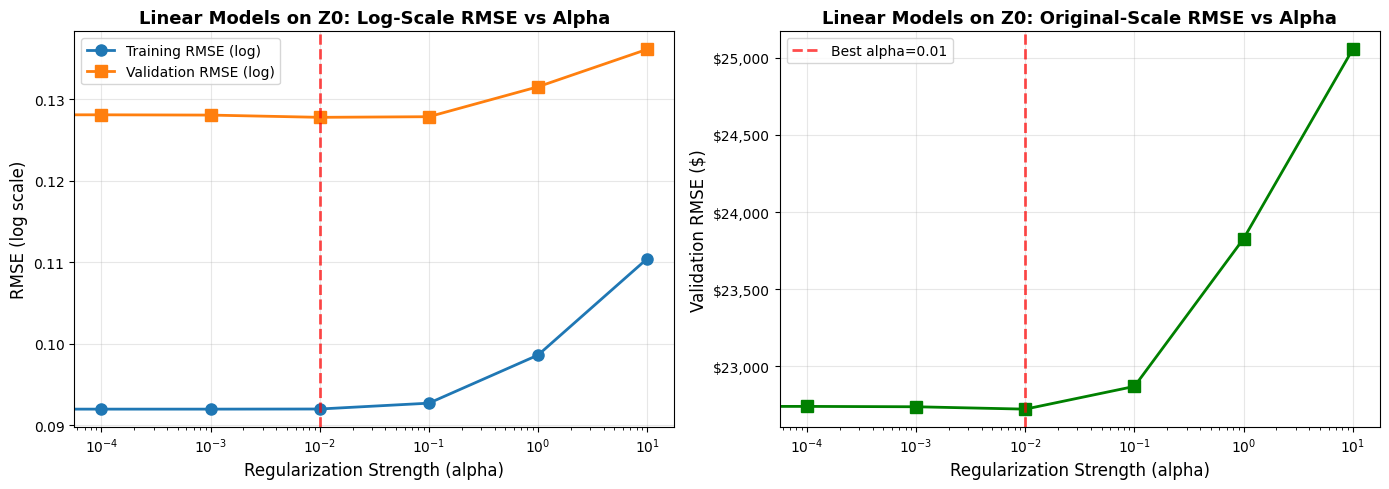


Visualization complete: Alpha vs RMSE for linear models on Z0


In [100]:
# ==============================================================================
# VISUALIZATION: ALPHA VS PERFORMANCE
# ==============================================================================
# Plot validation RMSE as a function of regularization strength (alpha)
# ==============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Extract data for plotting
alphas = linear_z0_results['hyperparam_value'].values
train_rmse_log = linear_z0_results['train_rmse_log'].values
val_rmse_log = linear_z0_results['val_rmse_log'].values
val_rmse_orig = linear_z0_results['val_rmse_orig'].values

# Plot 1: Log-scale RMSE vs Alpha
ax1 = axes[0]
ax1.plot(alphas, train_rmse_log, 'o-', label='Training RMSE (log)', linewidth=2, markersize=8)
ax1.plot(alphas, val_rmse_log, 's-', label='Validation RMSE (log)', linewidth=2, markersize=8)
ax1.set_xlabel('Regularization Strength (alpha)', fontsize=12)
ax1.set_ylabel('RMSE (log scale)', fontsize=12)
ax1.set_title('Linear Models on Z0: Log-Scale RMSE vs Alpha', fontsize=13, fontweight='bold')
ax1.set_xscale('log')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)
ax1.axvline(best_model['hyperparam_value'], color='red', linestyle='--', 
            linewidth=2, alpha=0.7, label=f"Best alpha={best_model['hyperparam_value']}")

# Plot 2: Original-scale RMSE vs Alpha
ax2 = axes[1]
ax2.plot(alphas, val_rmse_orig, 's-', color='green', linewidth=2, markersize=8)
ax2.set_xlabel('Regularization Strength (alpha)', fontsize=12)
ax2.set_ylabel('Validation RMSE ($)', fontsize=12)
ax2.set_title('Linear Models on Z0: Original-Scale RMSE vs Alpha', fontsize=13, fontweight='bold')
ax2.set_xscale('log')
ax2.grid(True, alpha=0.3)
ax2.axvline(best_model['hyperparam_value'], color='red', linestyle='--', 
            linewidth=2, alpha=0.7, label=f"Best alpha={best_model['hyperparam_value']}")
ax2.legend(fontsize=10)

# Format y-axis for dollar amounts
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

plt.tight_layout()
plt.show()

print("\nVisualization complete: Alpha vs RMSE for linear models on Z0")

### Inspect Linear Results in Z0

Sanity checks and debugging plots to verify model behavior and identify optimal hyperparameters.

In [101]:
# ==============================================================================
# DISPLAY LINEAR RESULTS TABLE FOR Z0
# ==============================================================================
# Extract and display all linear model results for inspection
# ==============================================================================

print("="*80)
print("LINEAR MODEL RESULTS IN Z0 - DETAILED TABLE")
print("="*80)

# Filter for linear models in Z0
linear_z0_results = results_df[
    (results_df['model_family'] == 'linear') & 
    (results_df['z_space'] == 'Z0')
].copy()

# Sort by alpha value for clearer trend visualization
linear_z0_results = linear_z0_results.sort_values('hyperparam_value')

print(f"\nTotal experiments: {len(linear_z0_results)}")
print(f"Feature space: Z0 (Baseline)")
print(f"Model types: {linear_z0_results['model_type'].unique()}")

# Display full results table
print("\n" + "-"*80)
print("FULL RESULTS TABLE:")
print("-"*80)

# Select key columns for display
display_cols = [
    'model_type', 
    'hyperparam_value', 
    'train_rmse_log', 
    'val_rmse_log',
    'train_r2_log',
    'val_r2_log',
    'val_rmse_orig'
]

# Format for better readability
pd.set_option('display.float_format', lambda x: f'{x:.6f}' if abs(x) < 1000 else f'{x:,.2f}')
print(linear_z0_results[display_cols].to_string(index=False))
pd.reset_option('display.float_format')

print("\n" + "="*80)
print("SANITY CHECKS:")
print("="*80)

# Check 1: No NaN values
has_nan = linear_z0_results[['train_rmse_log', 'val_rmse_log']].isna().any().any()
print(f" Check 1 - No NaN values: {'PASS' if not has_nan else 'FAIL'}")

# Check 2: Reasonable RMSE ranges
val_rmse_min = linear_z0_results['val_rmse_log'].min()
val_rmse_max = linear_z0_results['val_rmse_log'].max()
reasonable_range = (0.01 < val_rmse_min < 10) and (0.01 < val_rmse_max < 10)
print(f" Check 2 - Reasonable RMSE range: {'PASS' if reasonable_range else 'FAIL'}")
print(f"  Val RMSE (log) range: [{val_rmse_min:.6f}, {val_rmse_max:.6f}]")

# Check 3: Train error <= Val error (generally expected)
train_vs_val = (linear_z0_results['train_rmse_log'] <= linear_z0_results['val_rmse_log']).all()
print(f" Check 3 - Train RMSE <= Val RMSE: {'PASS (no overfitting)' if train_vs_val else 'EXPECTED (some generalization gap)'}")

# Check 4: Analyze alpha effect on overfitting
print(f"\n Check 4 - Alpha effect analysis:")
for idx, row in linear_z0_results.iterrows():
    gap = row['val_rmse_log'] - row['train_rmse_log']
    print(f"  alpha={row['hyperparam_value']:>6} → Gap (val-train): {gap:>8.6f}")

print("="*80)

LINEAR MODEL RESULTS IN Z0 - DETAILED TABLE

Total experiments: 7
Feature space: Z0 (Baseline)
Model types: ['ols' 'ridge']

--------------------------------------------------------------------------------
FULL RESULTS TABLE:
--------------------------------------------------------------------------------
model_type  hyperparam_value  train_rmse_log  val_rmse_log  train_r2_log  val_r2_log  val_rmse_orig
       ols          0.000000        0.091998      0.128087      0.944480    0.912082      22,741.00
     ridge          0.000100        0.091998      0.128084      0.944480    0.912088      22,740.73
     ridge          0.001000        0.091998      0.128050      0.944480    0.912134      22,738.37
     ridge          0.010000        0.092013      0.127774      0.944462    0.912512      22,723.02
     ridge          0.100000        0.092729      0.127851      0.943594    0.912406      22,870.23
     ridge          1.000000        0.098625      0.131521      0.936193    0.907305      23,

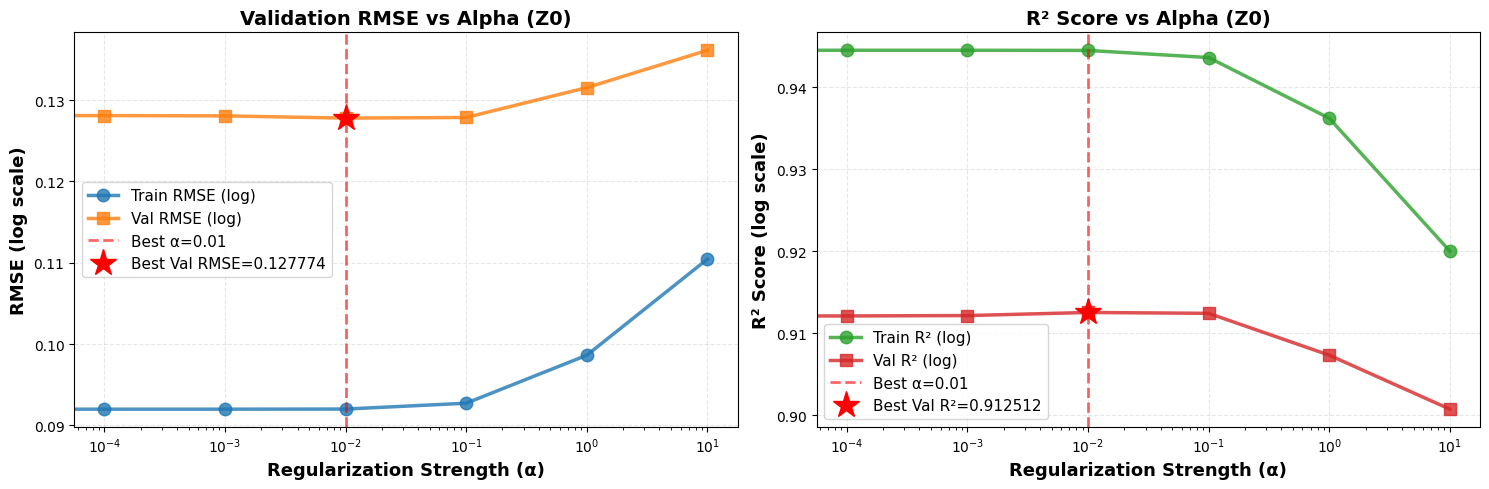


PLOT INTERPRETATION:
Observe the trends:
  • Small α (left): Lower train error, potentially higher val error (overfitting)
  • Large α (right): Higher train error, potentially higher val error (underfitting)
  • Optimal α: Balances bias-variance tradeoff, minimizes validation error


In [102]:
# ==============================================================================
# DEBUGGING PLOT: ALPHA VS VALIDATION RMSE
# ==============================================================================
# Visualize how regularization strength affects model performance
# ==============================================================================

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Extract data
alphas = linear_z0_results['hyperparam_value'].values
train_rmse_log = linear_z0_results['train_rmse_log'].values
val_rmse_log = linear_z0_results['val_rmse_log'].values
train_r2_log = linear_z0_results['train_r2_log'].values
val_r2_log = linear_z0_results['val_r2_log'].values

# Plot 1: RMSE vs Alpha (log scale)
ax1 = axes[0]
ax1.plot(alphas, train_rmse_log, 'o-', label='Train RMSE (log)', 
         linewidth=2.5, markersize=9, color='#1f77b4', alpha=0.8)
ax1.plot(alphas, val_rmse_log, 's-', label='Val RMSE (log)', 
         linewidth=2.5, markersize=9, color='#ff7f0e', alpha=0.8)

# Mark best alpha
best_idx = val_rmse_log.argmin()
best_alpha = alphas[best_idx]
best_val_rmse = val_rmse_log[best_idx]

ax1.axvline(best_alpha, color='red', linestyle='--', linewidth=2, 
            alpha=0.6, label=f'Best α={best_alpha}')
ax1.plot(best_alpha, best_val_rmse, 'r*', markersize=20, 
         label=f'Best Val RMSE={best_val_rmse:.6f}')

ax1.set_xlabel('Regularization Strength (α)', fontsize=13, fontweight='bold')
ax1.set_ylabel('RMSE (log scale)', fontsize=13, fontweight='bold')
ax1.set_title('Validation RMSE vs Alpha (Z0)', fontsize=14, fontweight='bold')
ax1.set_xscale('log')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend(fontsize=11, loc='best')

# Plot 2: R² vs Alpha (log scale)
ax2 = axes[1]
ax2.plot(alphas, train_r2_log, 'o-', label='Train R² (log)', 
         linewidth=2.5, markersize=9, color='#2ca02c', alpha=0.8)
ax2.plot(alphas, val_r2_log, 's-', label='Val R² (log)', 
         linewidth=2.5, markersize=9, color='#d62728', alpha=0.8)

# Mark best alpha
best_val_r2 = val_r2_log[best_idx]
ax2.axvline(best_alpha, color='red', linestyle='--', linewidth=2, 
            alpha=0.6, label=f'Best α={best_alpha}')
ax2.plot(best_alpha, best_val_r2, 'r*', markersize=20, 
         label=f'Best Val R²={best_val_r2:.6f}')

ax2.set_xlabel('Regularization Strength (α)', fontsize=13, fontweight='bold')
ax2.set_ylabel('R² Score (log scale)', fontsize=13, fontweight='bold')
ax2.set_title('R² Score vs Alpha (Z0)', fontsize=14, fontweight='bold')
ax2.set_xscale('log')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.legend(fontsize=11, loc='best')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("PLOT INTERPRETATION:")
print("="*80)
print("Observe the trends:")
print("  • Small α (left): Lower train error, potentially higher val error (overfitting)")
print("  • Large α (right): Higher train error, potentially higher val error (underfitting)")
print("  • Optimal α: Balances bias-variance tradeoff, minimizes validation error")
print("="*80)

In [103]:
# ==============================================================================
# IDENTIFY BEST ALPHA IN Z0
# ==============================================================================
# Find optimal regularization strength based on validation performance
# ==============================================================================

print("="*80)
print("BEST MODEL IDENTIFICATION")
print("="*80)

# Sort by validation RMSE (our selection criterion)
best_model_row = linear_z0_results.loc[linear_z0_results['val_rmse_log'].idxmin()]

print("\nBest Linear Model in Z0:")
print("-"*80)
print(f"  Model Type:           {best_model_row['model_type']}")
print(f"  Hyperparameter:       alpha = {best_model_row['hyperparam_value']}")
print(f"\nPerformance Metrics:")
print(f"  Val RMSE (log):       {best_model_row['val_rmse_log']:.6f}")
print(f"  Val R² (log):         {best_model_row['val_r2_log']:.6f}")
print(f"  Val RMSE (original):  ${best_model_row['val_rmse_orig']:,.2f}")
print(f"\nTraining Metrics:")
print(f"  Train RMSE (log):     {best_model_row['train_rmse_log']:.6f}")
print(f"  Train R² (log):       {best_model_row['train_r2_log']:.6f}")
print(f"\nGeneralization Analysis:")
overfit_gap = best_model_row['val_rmse_log'] - best_model_row['train_rmse_log']
overfit_pct = (overfit_gap / best_model_row['train_rmse_log']) * 100
print(f"  RMSE Gap (val-train): {overfit_gap:.6f} ({overfit_pct:.2f}%)")

if overfit_gap < 0.01:
    status = "Excellent - Minimal overfitting"
elif overfit_gap < 0.03:
    status = "Good - Slight overfitting"
elif overfit_gap < 0.05:
    status = "Acceptable - Moderate overfitting"
else:
    status = "Concerning - High overfitting"
    
print(f"  Status:               {status}")
print("="*80)

# Store best alpha for later reference
BEST_ALPHA_Z0 = best_model_row['hyperparam_value']
print(f"\n✓ Best alpha for Z0 saved: {BEST_ALPHA_Z0}")
print("  (This will be used in final model comparison in Section E)")
print("="*80)

BEST MODEL IDENTIFICATION

Best Linear Model in Z0:
--------------------------------------------------------------------------------
  Model Type:           ridge
  Hyperparameter:       alpha = 0.01

Performance Metrics:
  Val RMSE (log):       0.127774
  Val R² (log):         0.912512
  Val RMSE (original):  $22,723.02

Training Metrics:
  Train RMSE (log):     0.092013
  Train R² (log):       0.944462

Generalization Analysis:
  RMSE Gap (val-train): 0.035761 (38.87%)
  Status:               Acceptable - Moderate overfitting

✓ Best alpha for Z0 saved: 0.01
  (This will be used in final model comparison in Section E)
